## Simple Higher Order Example with misspecification 

$$
\ddot x = -\sin(x)
$$

$$
\begin{align}
u_1 &\triangleq x\\
u_2 &\triangleq \dot x\\
\end{align}
$$

First order system
$$
\begin{align}
\dot u_1 &= u_2\\
\dot u_2 &= - \sin(u_1)
\end{align}
$$

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import jax
import jax.numpy as jnp
from jax.random import PRNGKey

import numpy as np
import matplotlib.pyplot as plt
import diffrax

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant, CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import (
    AlternatingActiveSetLMSolver,
    LMSettings,
    AnnealedAlternatingActiveSetLMSolver,
)
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

from jsindy.util import get_collocation_points_weights

from pysindy import STLSQ

# Configure
jax.config.update("jax_enable_x64", True)
plt.style.use("ggplot")

# Random key
seed = 1234
rkey = PRNGKey(seed=seed)

savefig = True
# save_folder = "figures_miss-specification/"


/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In [2]:
dt = 0.01
noise = 0.1
# noise = 0.0
dt_train = 1.

n_colloc = 500

x0 = 3.0       # initial displacement
# x0 = 1.0
dx0 = 0.0      # initial velocity

t0 = 0.0
t1 = 50.0
initial_state = jnp.array([x0, dx0])

args = None

def ode_sys(t, state, args):
    x, dx = state

    dxdt = dx
    dydt = -1*jnp.sin(x)
    return jnp.array([dxdt,dydt])

term = diffrax.ODETerm(ode_sys)
solver = diffrax.Tsit5()

save_at = diffrax.SaveAt(dense=True)

sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=dt,  # Initial step size
    y0=initial_state,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

In [3]:
t_true = jnp.arange(t0,t1,dt)
X_true = jax.vmap(sol.evaluate)(t_true)

t_train = jnp.arange(t0,t1, dt_train)
X_train_true = jax.vmap(sol.evaluate)(t_train)
X_train = X_train_true + noise*jax.random.normal(rkey,X_train_true.shape)

t_colloc, w_colloc = get_collocation_points_weights(t_train, n_colloc)



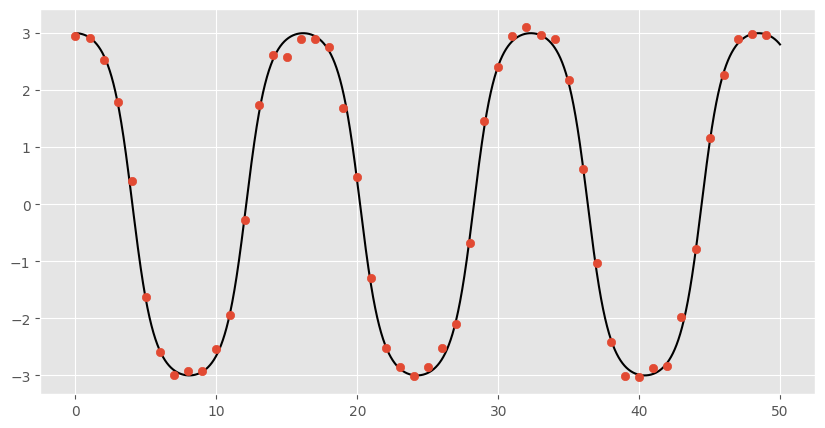

In [4]:
plt.figure(figsize=(10,5))
plt.plot(t_true, X_true[:,0],c='black')
plt.scatter(t_train, X_train[:,0],zorder=2)
plt.show()

In [5]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 3,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=3)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 10.
colloc_weight = 1.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
    beta_reg=1e-5,
    solver_settings=optsettings,
    fixed_colloc_weight=colloc_weight,
    fixed_data_weight=data_weight,
    sparsifier = sparsifier,
    # num_annealing_steps=3,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0, 1),
    ode_order=2,
    feature_names=['x']
)



In [6]:
model.fit(
    t = t_train,
    x = X_train[:,0].reshape(-1,1),
    t_colloc=t_colloc
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.01242929, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 1.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 1.353, gradnorm = 1.192, alpha = 4.167, improvement_ratio = 0.9999
Iteration 1, loss = 1.292, gradnorm = 0.6091, alpha = 3.472, improvement_ratio = 0.9999
Iteration 2, loss = 1.24, gradnorm = 0.4801, alpha = 2.894, improvement_ratio = 0.9999
Iteration 3, loss = 1.191, gradnorm = 0.4102, alpha = 2.411, improvement_ratio = 0.9999
Iteration 4, loss = 1.141, gradnorm = 0.3689, alpha = 2.009, improvement_ratio = 0.9999
Iteration 5, loss = 1.089, gradnorm = 0.3403, alpha = 1.674, improvement_ratio = 0.9999
Iteration 77, loss = 0.07768, gradnorm = 9.146e-09, alpha = 3.333e-06, improvement_ratio = 1.313
Model after smooth warm start
(x)'' = 0.236 1 + 0.098 x + 0.121 (x') + -0.028 x^2 + -0.056 x (x') + -0.083 (x')^2 + -0.021 x^3 + -0.038 x^2 (x') + -0.356 x (x')^2 + 0.005 (x')^3
Alternating Activeset Sparsifier
7 active coeffs changed
Active set stabilized


In [7]:
model.print()

(x)'' = -0.081 x + -0.056 x (x') + -0.290 x (x')^2


## Predict higher order dynamics

In [8]:
ddx_pred = model.predict(X_true)

In [9]:
# X_true

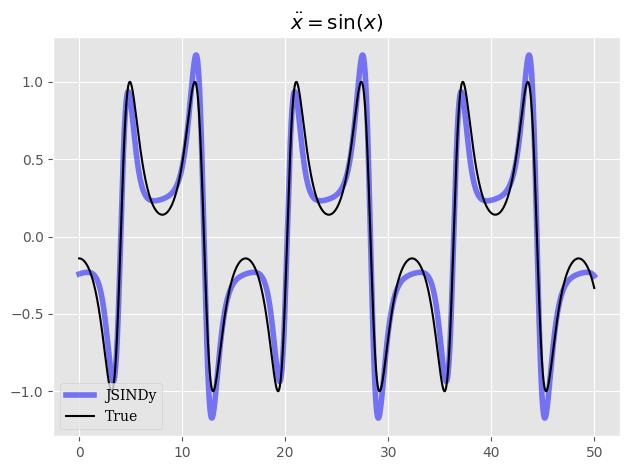

In [10]:
plt.plot(t_true, ddx_pred, c='blue', alpha=0.5, lw=4, label='JSINDy')
plt.plot(t_true, -jnp.sin(X_true[:,0]), c='black', label="True")
plt.title(r"$\ddot{x} = \sin(x)$", family='serif')
plt.legend(prop={'family':'serif'})
plt.tight_layout()
plt.show()

## State prediction

In [11]:
x_pred = model.predict_state(t_true)

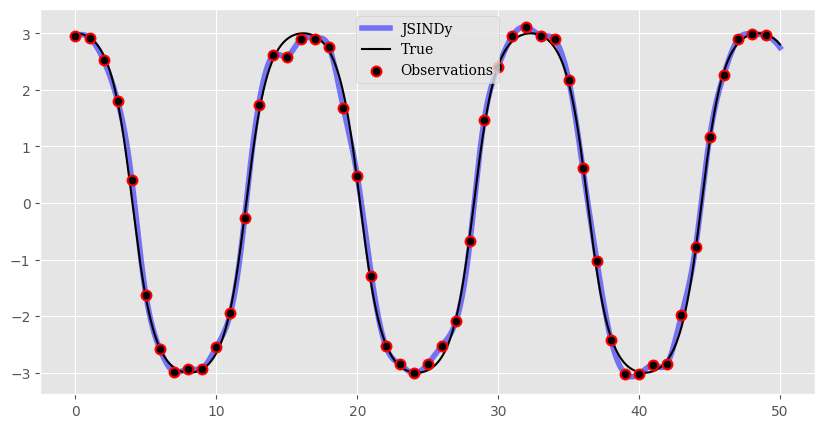

In [12]:
plt.figure(figsize=(10,5))
plt.plot(t_true, x_pred, label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true, X_true[:,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 2, facecolors='black', edgecolors='red', label="Observations", s=50,lw=1.5)
plt.legend(prop={'family':'serif'})
plt.show()

In [13]:



model.predict(X_true)

Array([[-0.24221073],
       [-0.24197424],
       [-0.24174006],
       ...,
       [-0.25257131],
       [-0.25339075],
       [-0.25423207]], dtype=float64)

## Plot with simulated results

In [14]:
ode_sys = jax.jit(ode_sys)

ode_sys_pred = jax.jit(model.predict)

def model_ode_sys(t, state, args):
    x, dx = state
    # print(dx)
    # print(state)
    # print(ode_sys_pred(state))
    return jnp.array([dx, ode_sys_pred(state)[0]])


# model_ode_sys = lambda t, x, args: ode_sys_pred(x)

In [15]:
model_ode_sys(None, X_true[-1], None)

Array([-0.30624317, -0.25423207], dtype=float64)

In [16]:
def simulate_sol(y0,system, t0=t0,t1=t1,dt=dt,t_eval =t_true, args = None):
    term = diffrax.ODETerm(system)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt)
    )

    return jax.vmap(sol.evaluate)(t_eval)

In [17]:
X_train[-1]

Array([ 2.96117257, -0.12706289], dtype=float64)

In [18]:
t_eval = jnp.arange(t0, t1*2, dt)

In [19]:
t_eval[-1]

Array(99.99, dtype=float64)

In [20]:
x_true_extend = simulate_sol(X_true[0], system=ode_sys,t_eval=t_eval, t1=t1*2)
x_model_extend = simulate_sol(X_true[0], system=model_ode_sys, t_eval=t_eval,t1=t1*2)

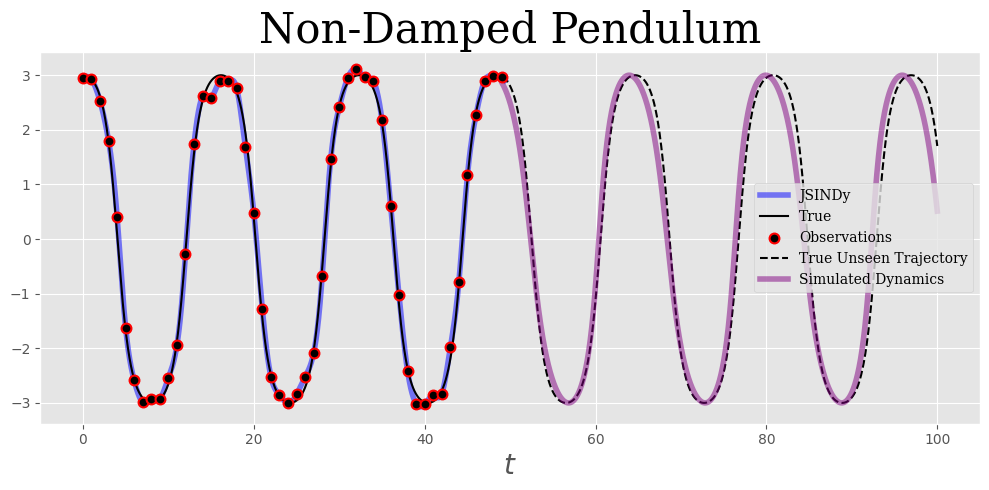

In [21]:
cutoff = -60
plt.figure(figsize=(10,5))
plt.plot(t_true[:cutoff], x_pred[:cutoff], label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true[:cutoff], X_true[:cutoff,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=50,lw=1.5)

# extension
# t_extend = t_true + t_true[cutoff]
new_cutoff = len(t_true) + cutoff + -30

plt.plot(t_eval[new_cutoff:], x_true_extend[new_cutoff:,0],linestyle="--", c='black', label="True Unseen Trajectory")
plt.plot(t_eval[new_cutoff:], x_model_extend[new_cutoff:,0], c='purple', lw=4, label="Simulated Dynamics",alpha=0.5)

plt.xlabel(r"$t$",size=20, family='serif')
plt.legend(prop={'family':'serif'},loc='right')
plt.title(r"Non-Damped Pendulum",size=30, family='serif')
plt.tight_layout()
if savefig: 
    plt.savefig("non-damped-pendulum.pdf")
plt.show()